### Link to the file with meta information on recordings

In [14]:
database_path = 'your path../Anesthesia_CA1/meta_data/meta_recordings - anesthesia.xlsx'

### Select the range of recordings for the analysis (see "Number" row in the meta data file)

In [4]:
rec = [x for x in range(0,189)]

In [1]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.signal import medfilt 

from scipy.stats import skew, kurtosis, zscore

from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

plt.rcParams['figure.figsize'] = [16, 8]

color_awake = (0,191/255,255/255)
color_mmf = (245/255,143/255,32/255)
color_keta = (181./255,34./255,48./255)
color_iso = (143./255,39./255,143./255)

custom_palette ={'keta':color_keta, 'iso':color_iso,'fenta':color_mmf,'awa':color_awake}

In [2]:
from capipeline import *

/media/andrey/My Passport/OASIS-master/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


### Run the analysis

It creates a data frame *df_estimators* that contains basic information regarding stability of the recordings, such as 

- total number of identified neurons,
- traces and neuropils median inntensities for each ROI
- their standard deviation
- skewness of the signal
- estamation of their baseline (defined as a bottom quartile of signal intensities) 
- their temporal stability (defined as the ratio between median signals of all ROIs in the first and the second parts of the recording)  

In [5]:
df_estimators = pd.DataFrame()

for r in rec:
    
    Traces, Npils, n_accepted_and_rejected = traces_and_npils(r, database_path, concatenation=False)
    
    animal = get_animal_from_recording(r, database_path)
        
    condition = get_condition(r, database_path)
    
    print("#" +  str(r) + " " + str(animal) + " " + str(condition) + " ")
    
    Traces_median = ma.median(Traces, axis=1) 
    Npils_median = ma.median(Npils, axis=1)
    
    Traces_std = ma.std(Npils, axis=1)    
    Npils_std = ma.std(Npils, axis=1)
    
    Traces_skewness = skew(Traces,axis=1)
    Npils_skewness = skew(Npils,axis=1)
    
    baseline = np.quantile(Traces,0.25,axis=1)
    
    recording_length = int(Traces.shape[1]/2)
    
    half = int(recording_length/2)

    traces_median_half_vs_half = (ma.median(Traces[:,:half])/ma.median(Traces[:,half:]))*100
    
    df_e = pd.DataFrame({ "animal":animal,
                        "recording":r,
                        "condition":condition,
                        "number.neurons":n_accepted_and_rejected,
                        "traces.median":Traces_median,
                        "npils.median":Npils_median,
                        "traces.std":Traces_std,
                        "npils.std":Npils_std,
    
                        "traces.skewness":Traces_skewness,
                        "npils.skewness":Npils_skewness,
     
                        "baseline.quantile.25":baseline,
                         
                        "median.stability":traces_median_half_vs_half # in percent

                      })
        
    df_estimators = pd.concat([df_estimators,df_e])

    print("*****")

    
#df_estimators['neuronID'] = df_estimators.index

#0 37527 keta 
*****
#1 37527 keta 
*****
#2 37527 keta 
*****
#3 37527 keta 
*****
#4 37528 keta 
*****
#5 37528 keta 
*****
#6 37528 keta 
*****
#7 37528 keta 
*****
#8 37529 keta 
*****
#9 37529 keta 
*****
#10 37529 keta 
*****
#11 37529 keta 
*****
#12 37530 keta 
*****
#13 37530 keta 
*****
#14 37530 keta 
*****
#15 37530 keta 
*****
#16 37527 iso 
*****
#17 37527 iso 
*****
#18 37527 iso 
*****
#19 37527 iso 
*****
#20 37528 iso 
*****
#21 37528 iso 
*****
#22 37528 iso 
*****
#23 37528 iso 
*****
#24 37529 iso 
*****
#25 37529 iso 
*****
#26 37529 iso 
*****
#27 37529 iso 
*****
#28 37530 iso 
*****
#29 37530 iso 
*****
#30 37530 iso 
*****
#31 37530 iso 
*****
#32 37527 fenta 
*****
#33 37527 fenta 
*****
#34 37527 fenta 
*****
#35 37527 fenta 
*****
#36 37528 fenta 
*****
#37 37528 fenta 
*****
#38 37528 fenta 
*****
#39 37528 fenta 
*****
#40 37529 fenta 
*****
#41 37529 fenta 
*****
#42 37529 fenta 
*****
#43 37529 fenta 
*****
#44 37530 fenta 
*****
#45 37530 fenta 
*****


### Save the result of the analysis

In [7]:
df_estimators.to_pickle("./calcium_imaging_stability_validation.pkl") 

### Load the result of the analysis

In [8]:
df_estimators = pd.read_pickle("./calcium_imaging_stability_validation.pkl") 

### Plot 

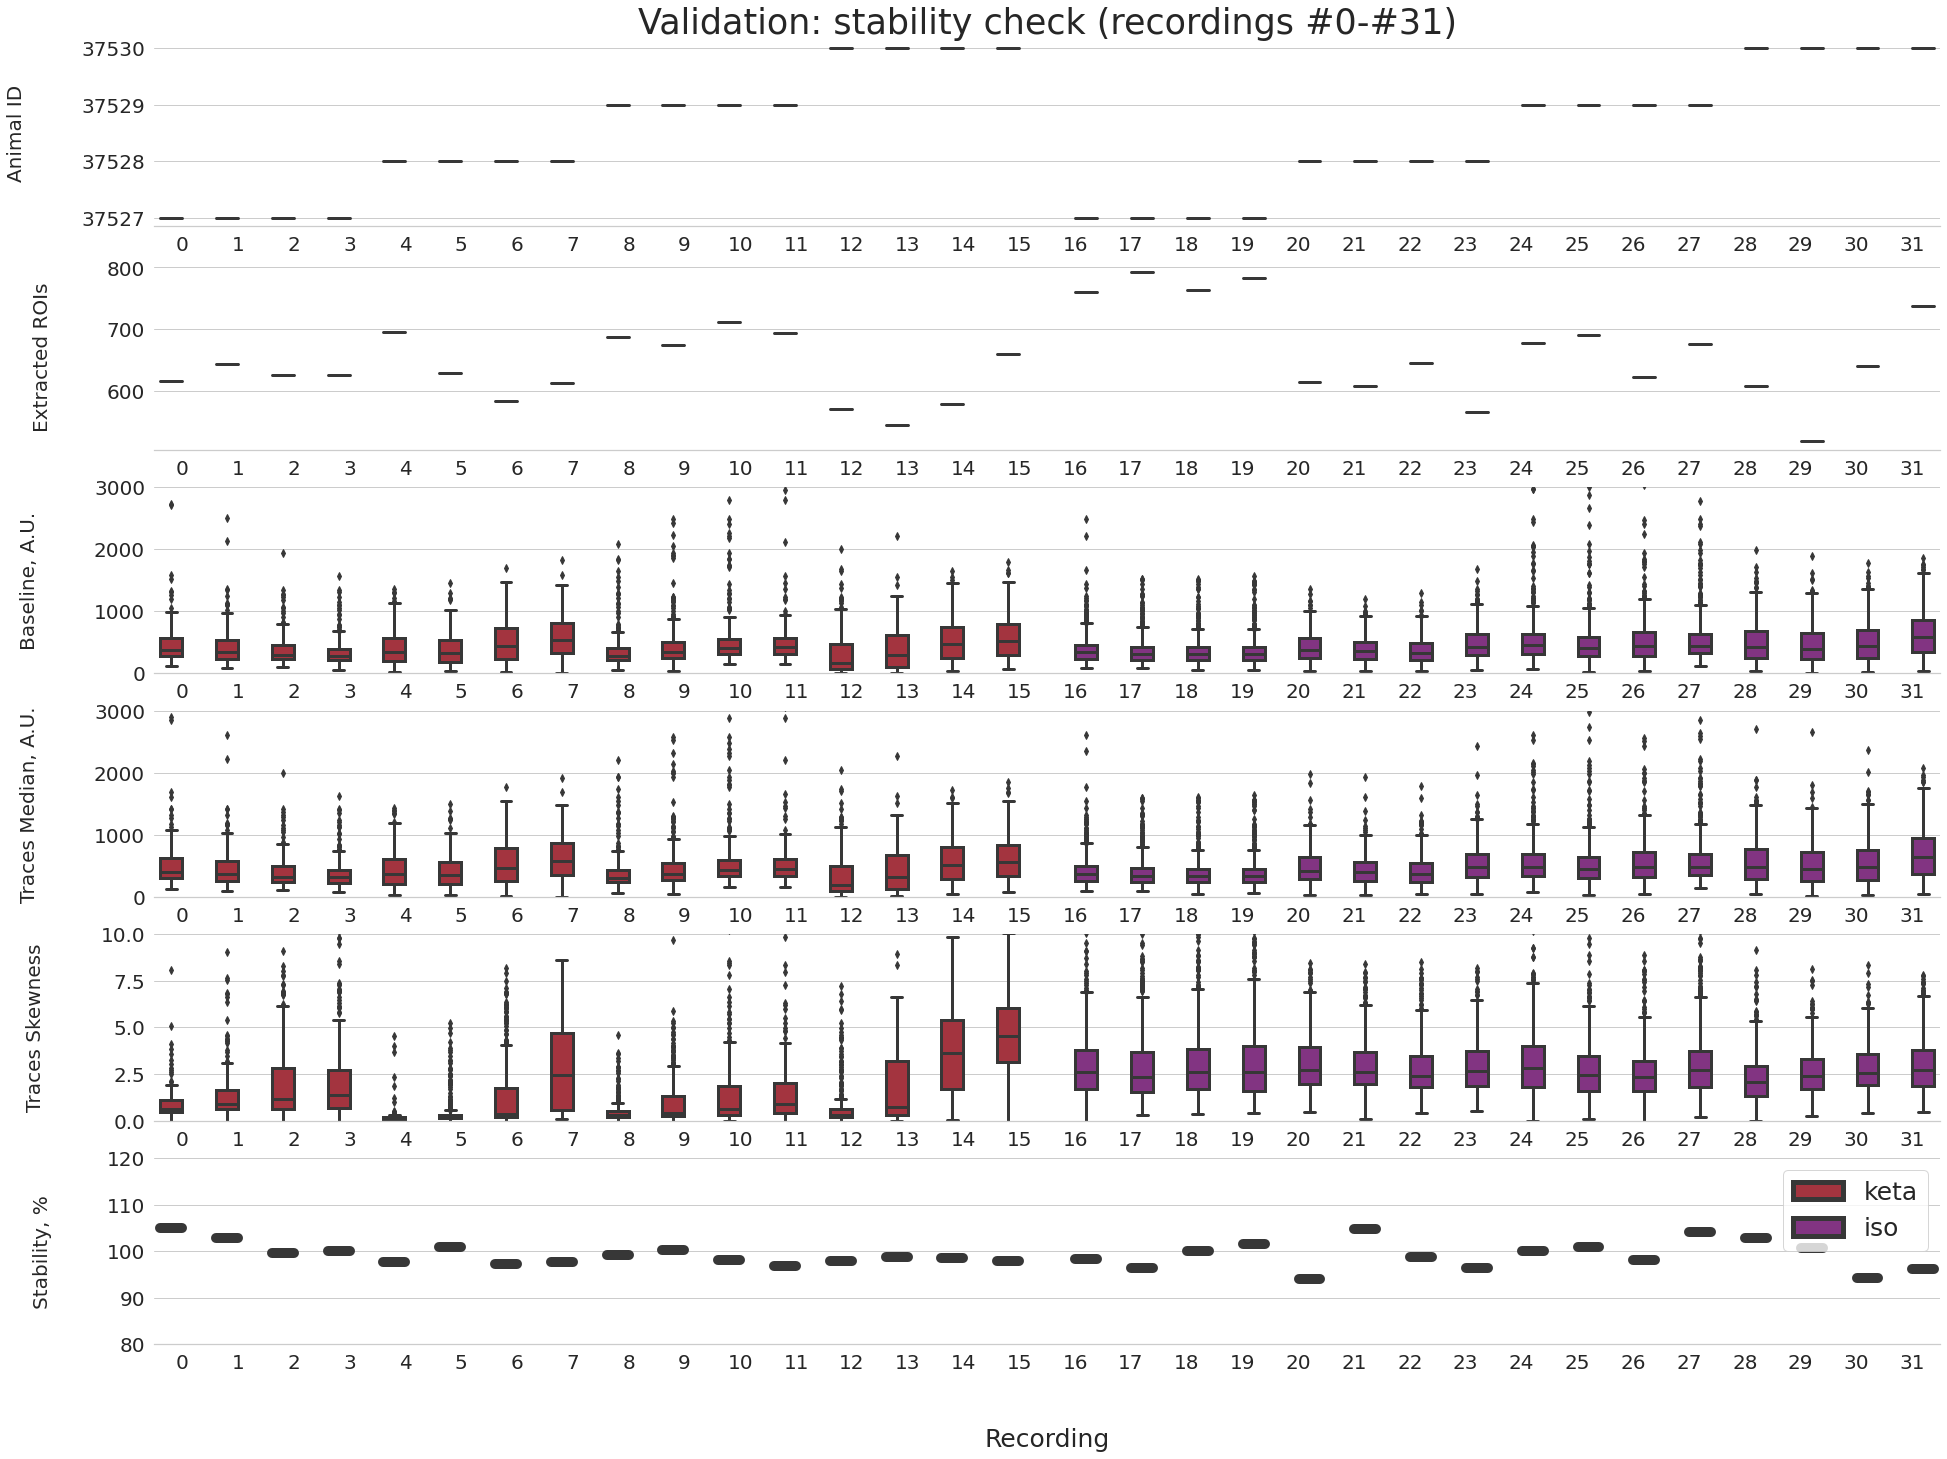

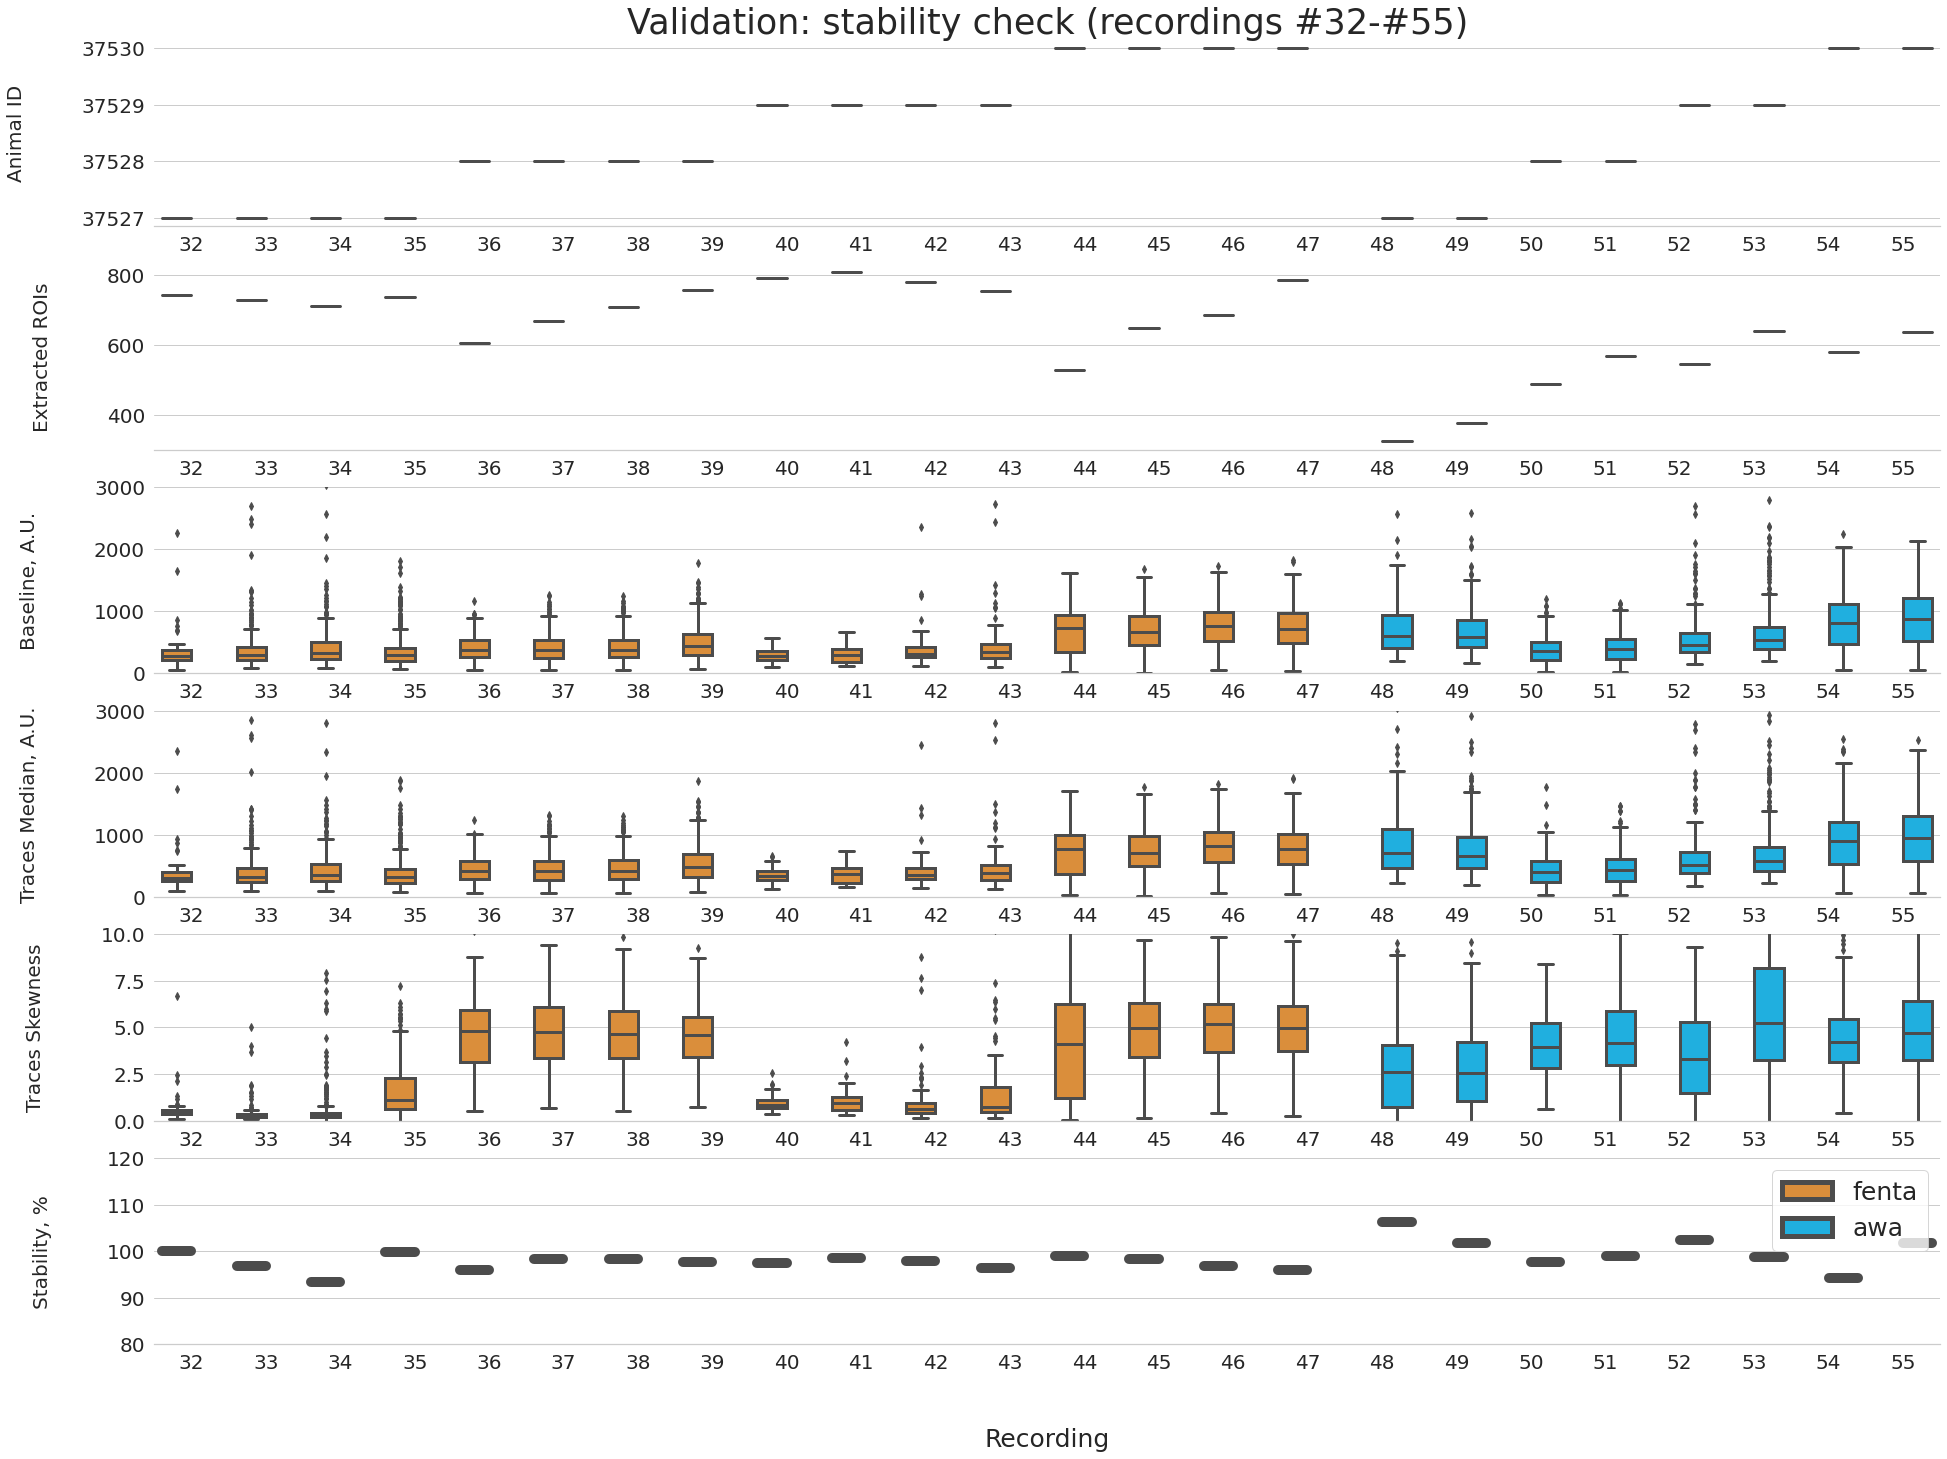

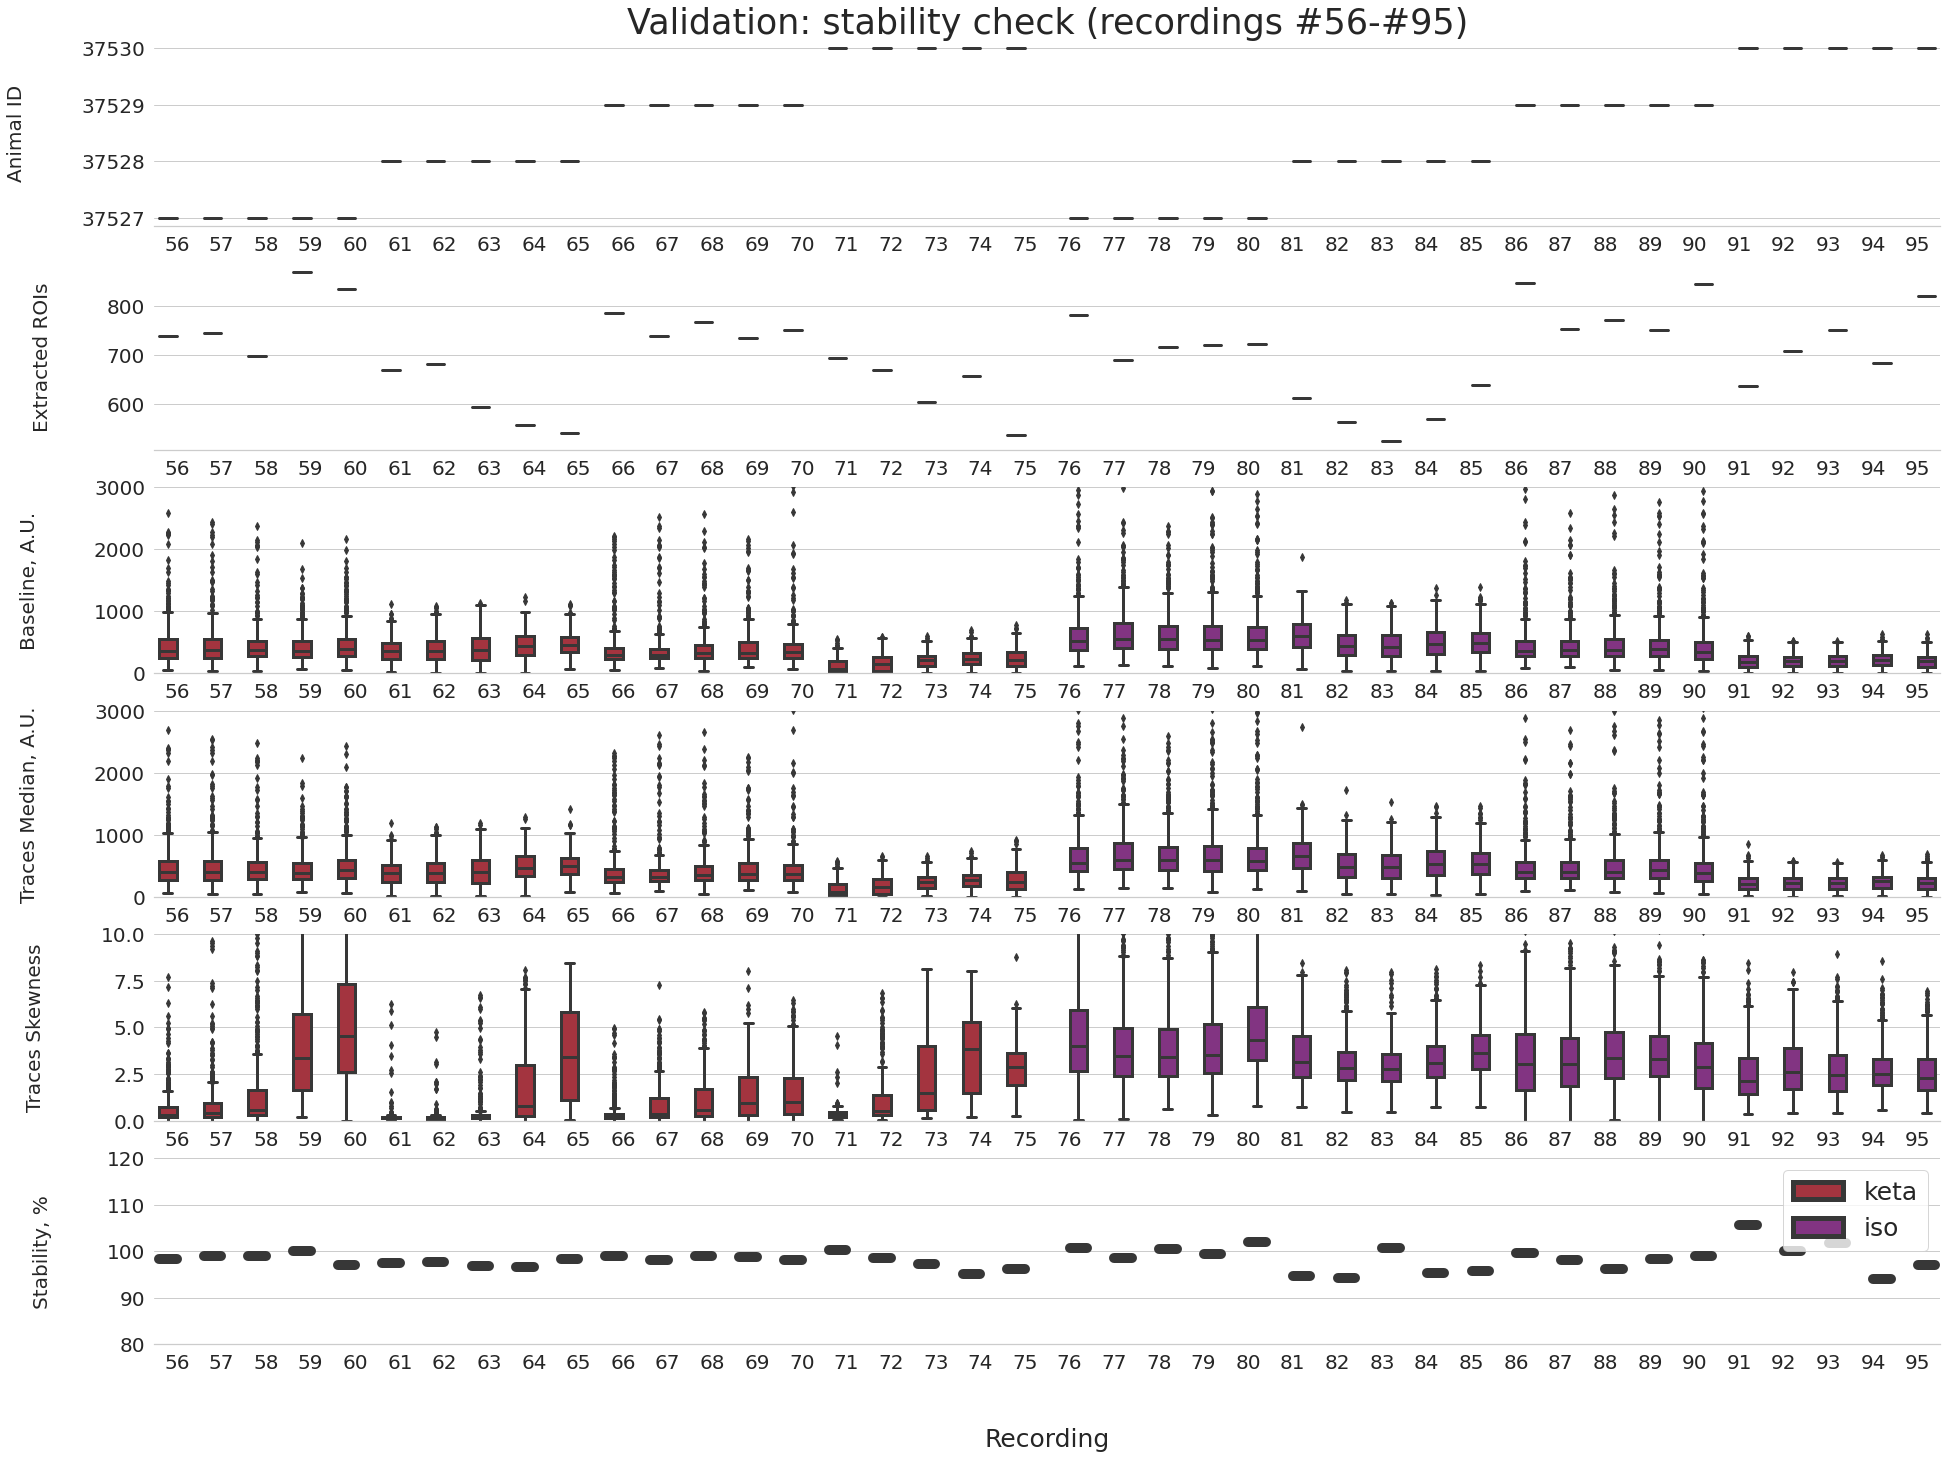

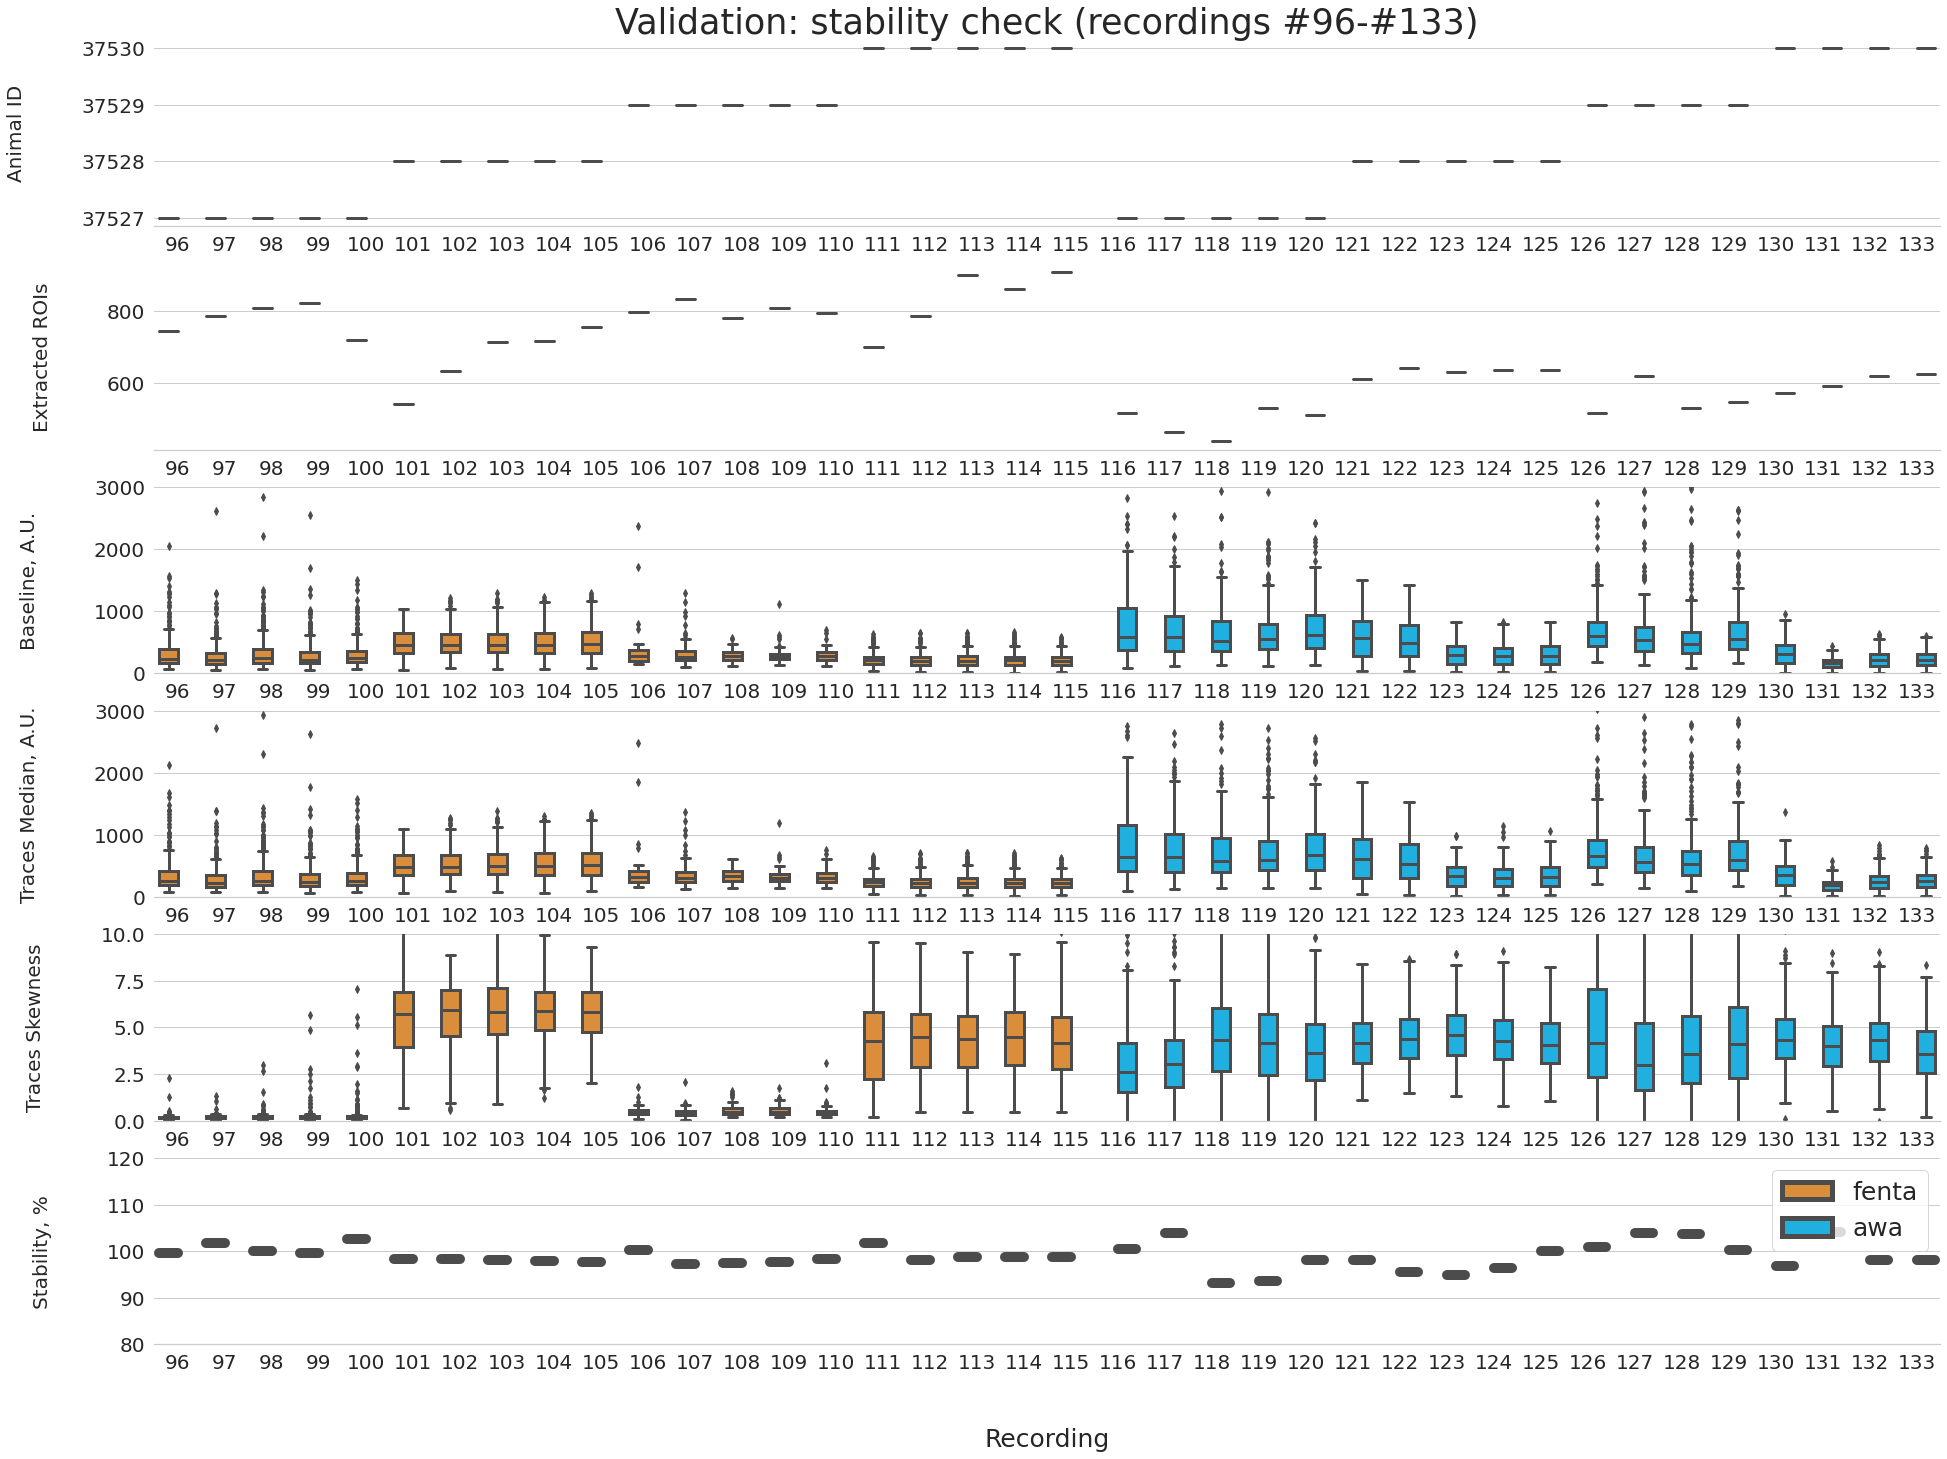

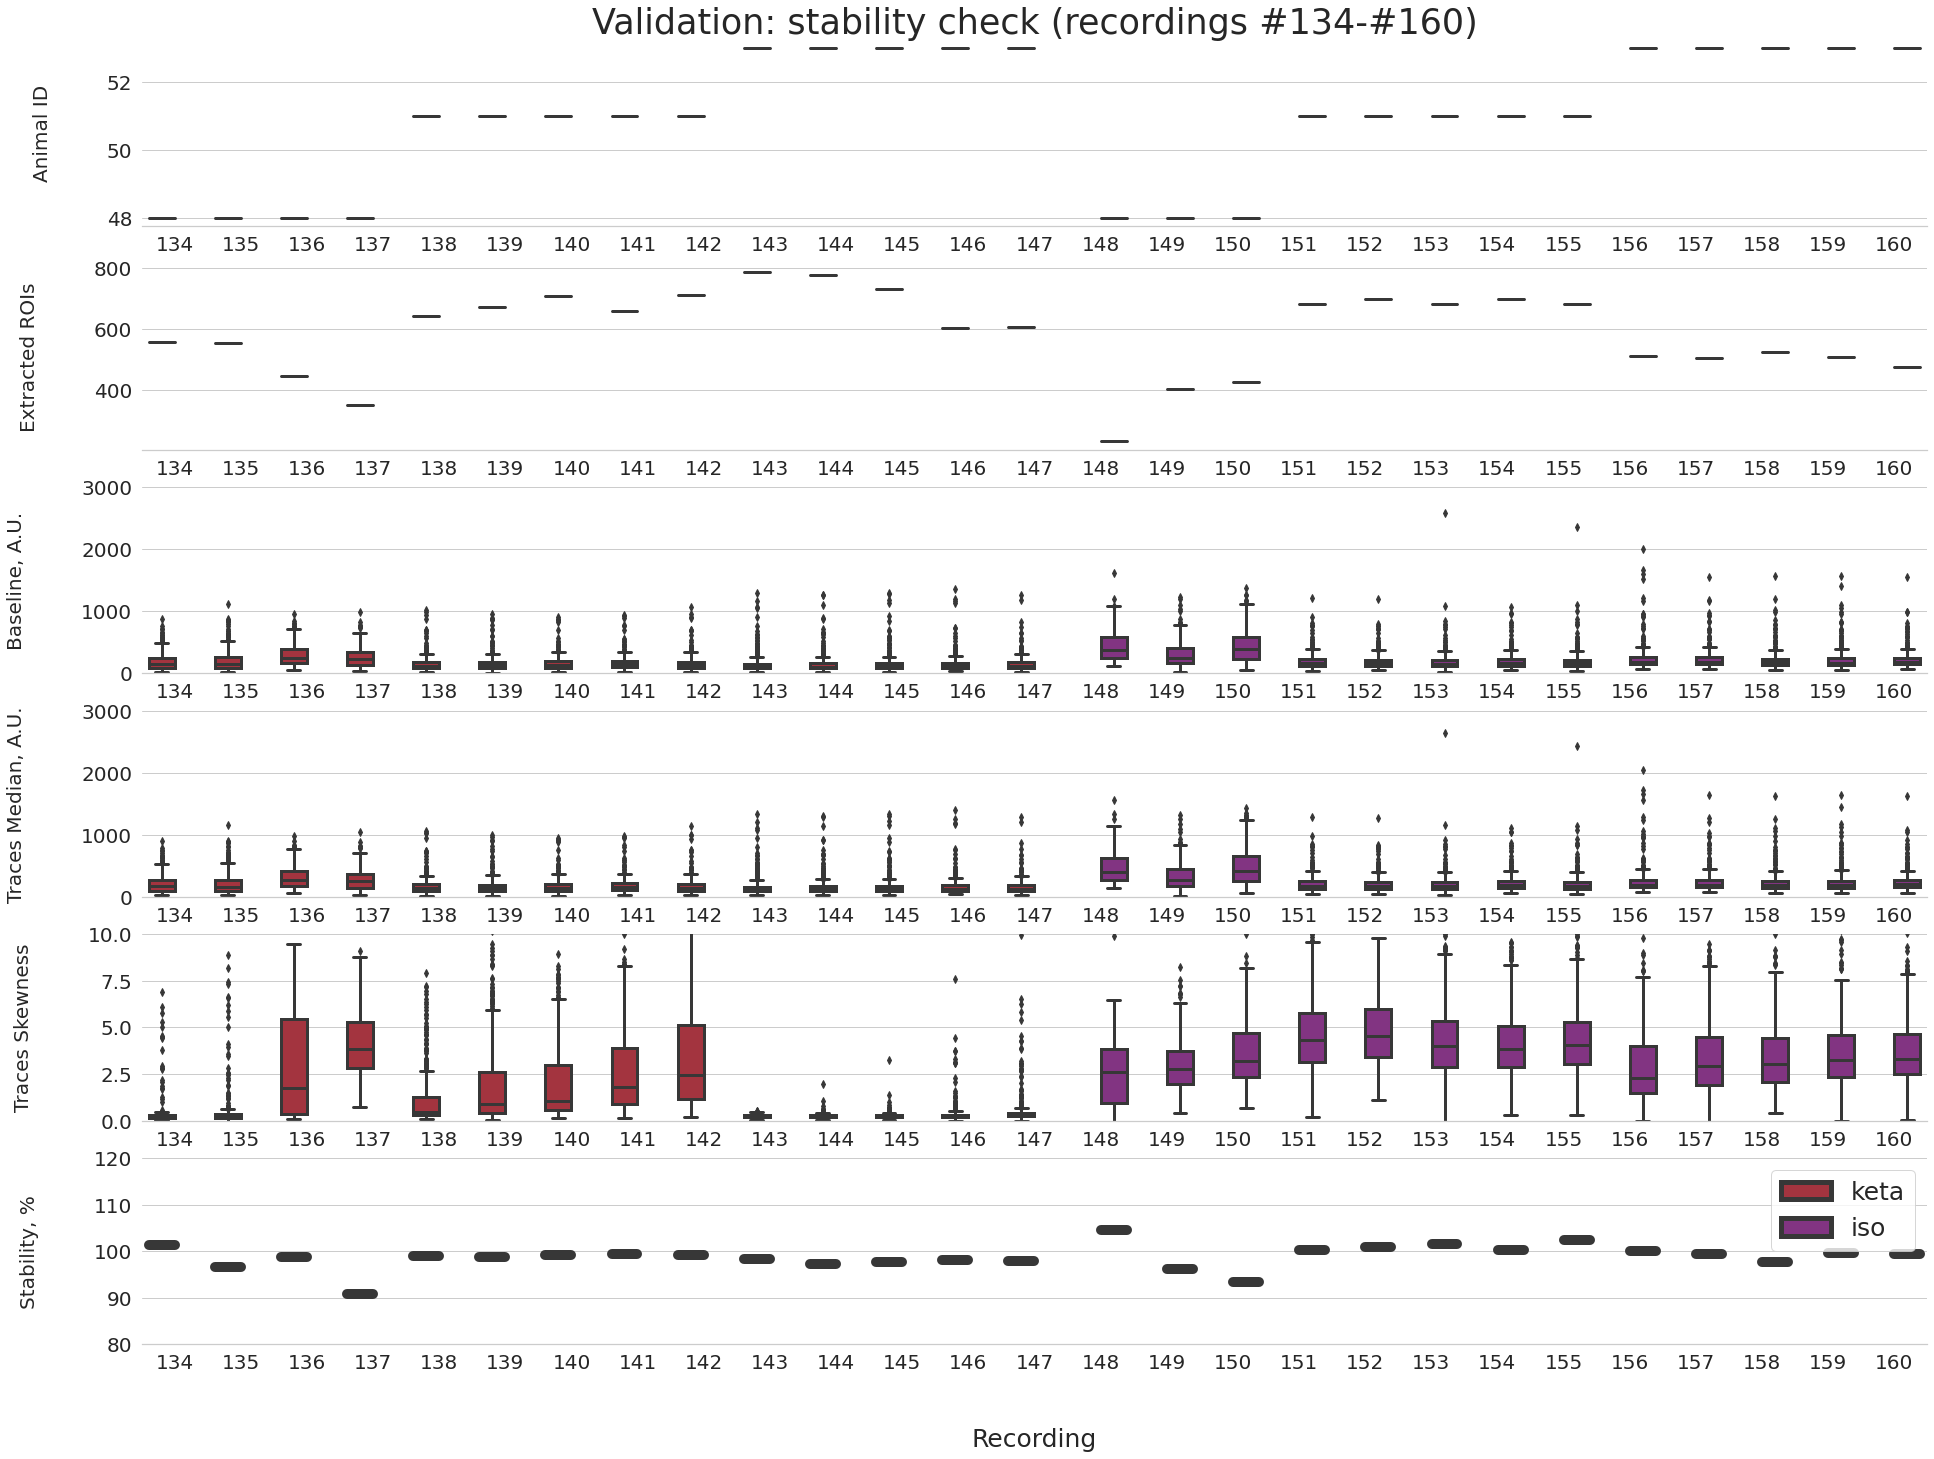

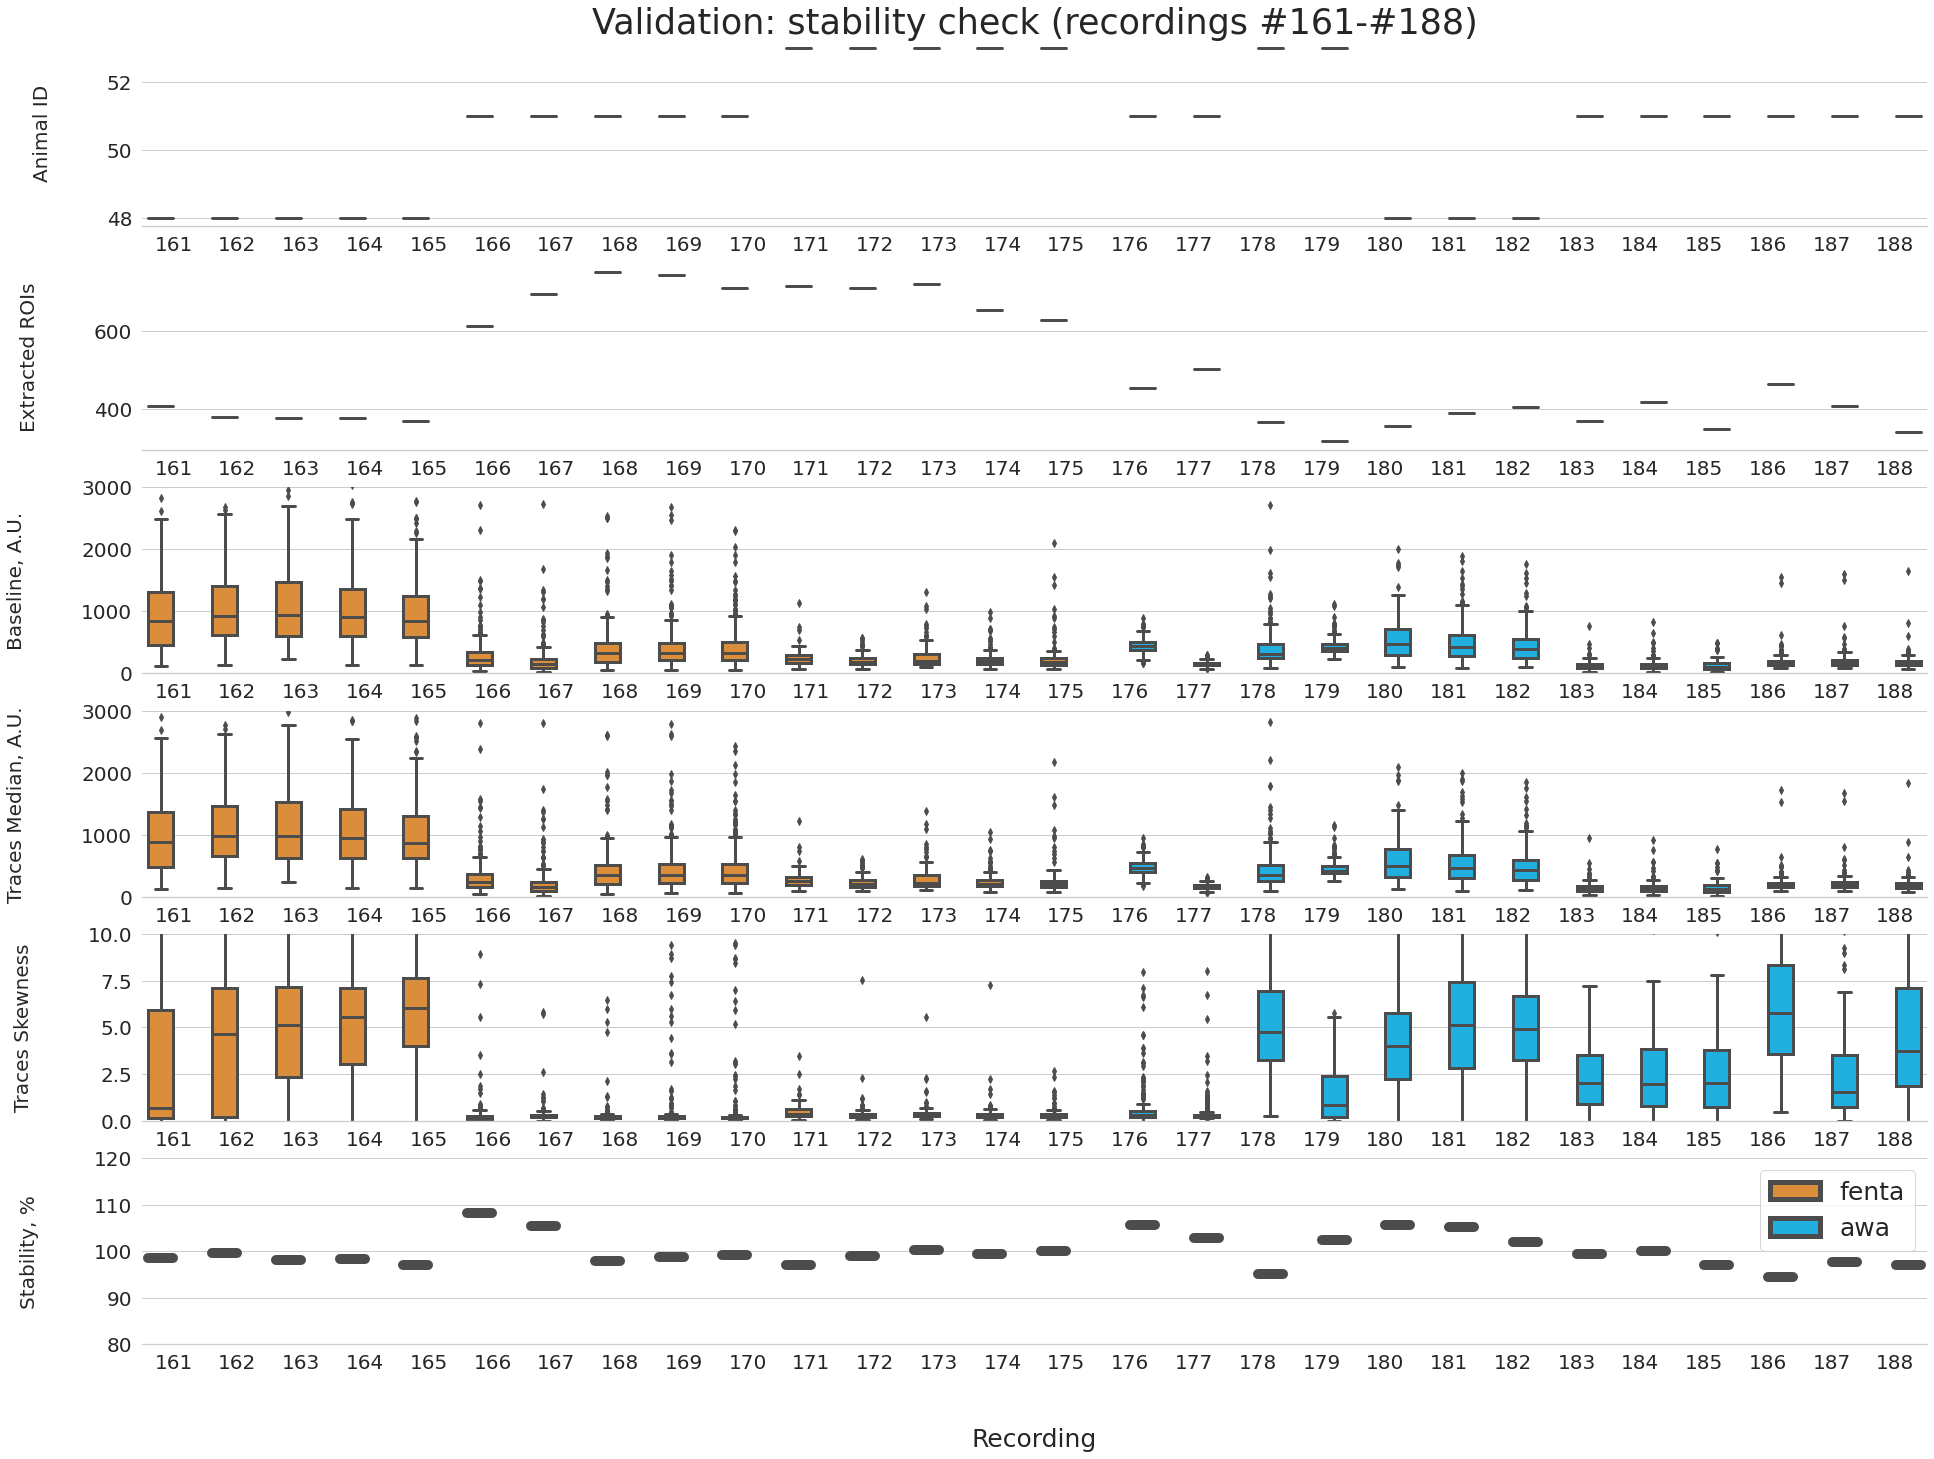

In [9]:
parameters = ["animal",'number.neurons','baseline.quantile.25','traces.median','traces.skewness','median.stability']
labels = ["Animal ID",'Extracted ROIs','Baseline, A.U.','Traces Median, A.U.','Traces Skewness','Stability, %']
number_subplots = len(parameters)
recordings_ranges = [[0,31],[32,55],[56,95],[96,133],[134,160],[161,188]]
#recordings_ranges = [[0,9],[10,19]] #test

for rmin,rmax in recordings_ranges:

    f, axes = plt.subplots(number_subplots, 1, figsize=(32, 24)) # sharex=Truerex=True
    sns.despine(left=True)

    for i, param in enumerate(parameters):
        
        lw = 3
        if i > 4:
            lw = 10
        
        sns.boxplot(x='recording', y=param, data=df_estimators[(df_estimators.recording>=rmin)&(df_estimators.recording<=rmax)], hue='condition', \
                    palette=custom_palette,ax=axes[i],linewidth=lw)
        
        if i > 1:
            axes[i].set_ylim([0.0,3000.0])
        if i > 3:
            axes[i].set_ylim([0.0,10.0])
        if i > 4:
            axes[i].set_ylim([80,120])
        if i < number_subplots-1:
            axes[i].xaxis.label.set_visible(False)
        if i==0:
            axes[i].set_title("Validation: stability check (recordings #%d-#%d)" % (rmin,rmax), fontsize=35)
        axes[i].set_ylabel(labels[i], fontsize=20,labelpad=55)
        axes[i].set_xlabel("Recording", fontsize=25,labelpad=55)
        axes[i].xaxis.set_tick_params(labelsize=20)
        axes[i].yaxis.set_tick_params(labelsize=20)
        axes[i].get_legend().remove()

    plt.legend(loc='upper right',fontsize=25)
    plt.savefig("Validation_stability_check_rec_#%d-#%d).png" % (rmin,rmax))
    plt.show()

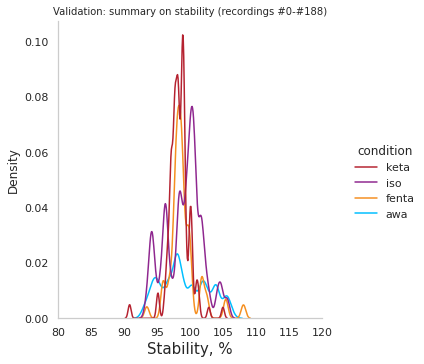

In [13]:
sns.displot(data=df_estimators, x="median.stability", hue = 'condition',palette=custom_palette, kind="kde")
plt.xlim([80,120])
plt.xlabel("Stability, %", fontsize = 15)
plt.title("Validation: summary on stability (recordings #%d-#%d)" % (min(rec),max(rec)), fontsize = 10)
plt.grid(False)
plt.savefig("Validation_summary_stability_recordings_#%d-#%d)" % (min(rec),max(rec)))
plt.show()

In [62]:
df_estimators["median.stability"].describe()

count    65887.000000
mean        98.883782
std          2.614005
min         90.832418
25%         97.582144
50%         98.731375
75%        100.151229
max        108.073246
Name: median.stability, dtype: float64